### Class 7- Starter code


In [2]:
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics
%pylab inline

Populating the interactive namespace from numpy and matplotlib


###Create sample data and fit a model

In [58]:
df = pd.DataFrame({'x': range(1000), 'y': range(1000)})
# NOTE: Whenever you make changes to dataframes and want to keep the original
# make sure you do a deep copy
biased_df  = df.copy(deep=True) 
biased_df.loc[:20, 'x'] = 1 # create a bias with both columns
biased_df.loc[:20, 'y'] = 1

def append_jitter(series):
    # adds uniform random variable to the input series
    jitter = np.random.random_sample(size=1000)
    return series + jitter

df['x'] = append_jitter(df.x)
df['y'] = append_jitter(df.y)

biased_df['x'] = append_jitter(biased_df.x)
biased_df['y'] = append_jitter(biased_df.y)


In [59]:
## fit
lm = linear_model.LinearRegression().fit(df[['x']], df['y'])
print metrics.mean_squared_error(df['y'], lm.predict(df[['x']]))


0.168750573078


In [60]:
## biased fit
lm = linear_model.LinearRegression().fit(biased_df[['x']], biased_df['y'])
print metrics.mean_squared_error(biased_df['y'], lm.predict(biased_df[['x']]))

0.166725709491


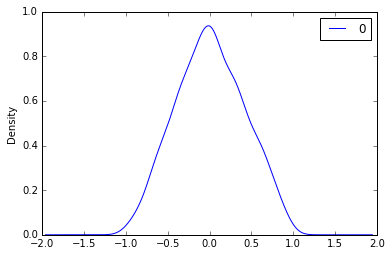

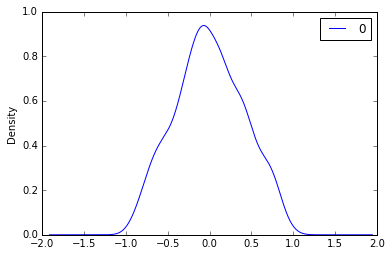

In [61]:
pd.DataFrame(lm.predict(biased_df[['x']])-lm.predict(biased_df[['y']])).plot(kind="density")
pd.DataFrame(lm.predict(df[['x']])-lm.predict(df[['y']])).plot(kind="density")

## Question - try to look at the distribution of the residuals for both biased_df and df

## Cross validation
#### Intro to cross validation with bike share data from last time. We will be modeling casual ridership. 

In [6]:
from sklearn import cross_validation
wd = '../../assets/dataset/'
bikeshare = pd.read_csv(wd + 'bikeshare.csv')

####Create dummy variables and set outcome (dependent) variable

In [62]:
weather = pd.get_dummies(bikeshare.weathersit, prefix='weather')
modeldata = bikeshare[['temp', 'hum']].join(weather[['weather_1', 'weather_2', 'weather_3']])
y = pd.DataFrame(bikeshare.casual)

#### Create a cross valiation with 5 folds

In [63]:
kf = cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True)
modeldata.shape

(17379, 5)

In [23]:
# kf basically contains 5 different test train sets of 80% and 20% split
for a in kf:
    print a
    print a[0].shape , a[1].shape

(array([    0,     1,     3, ..., 17376, 17377, 17378]), array([    2,    10,    20, ..., 17364, 17367, 17372]))
(13903,) (3476,)
(array([    0,     1,     2, ..., 17376, 17377, 17378]), array([    6,     7,    13, ..., 17366, 17368, 17375]))
(13903,) (3476,)
(array([    2,     3,     4, ..., 17375, 17376, 17377]), array([    0,     1,    25, ..., 17369, 17373, 17378]))
(13903,) (3476,)
(array([    0,     1,     2, ..., 17375, 17376, 17378]), array([    4,     8,    12, ..., 17359, 17370, 17377]))
(13903,) (3476,)
(array([    0,     1,     2, ..., 17375, 17377, 17378]), array([    3,     5,     9, ..., 17371, 17374, 17376]))
(13904,) (3475,)


In [64]:
mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))
    scores.append(lm.score(modeldata.iloc[test_index], y.iloc[test_index]))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]


print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of R2 for all folds:', np.mean(scores)

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 1596.71181554
R2: 0.315687927282
Model 2
MSE: 1779.41948552
R2: 0.297364280691
Model 3
MSE: 1609.52812215
R2: 0.315647354912
Model 4
MSE: 1768.56961786
R2: 0.310517120277
Model 5
MSE: 1612.52205656
R2: 0.318213490799
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 1673.35021953
Mean of R2 for all folds: 0.311486034792


In [40]:
lm = linear_model.LinearRegression().fit(modeldata, y)
print "~~~~ Single Model ~~~~"
print 'MSE of single model:', metrics.mean_squared_error(y, lm.predict(modeldata))
print 'R2: ', lm.score(modeldata, y)

~~~~ Single Model ~~~~
MSE of single model: 1672.58110765
R2:  0.311934605989


### Check
While the cross validated approach here generated more overall error, which of the two approaches would predict new data more accurately: the single model or the cross validated, averaged one? Why?


Answer: 

### There are ways to improve our model with regularization. 
Let's check out the effects on MSE and R2

In [41]:
modeldata.corr()

,temp,hum,weather_1,weather_2,weather_3
temp,1.000000,-0.069881,0.101044,-0.069657,-0.062406
hum,-0.069881,1.000000,-0.383425,0.220758,0.309737
weather_1,0.101044,-0.383425,1.000000,-0.822961,-0.412414
weather_2,-0.069657,0.220758,-0.822961,1.000000,-0.177417
weather_3,-0.062406,0.309737,-0.412414,-0.177417,1.000000


In [42]:
lm = linear_model.LinearRegression().fit(modeldata, y)
print "~~~ OLS ~~~"
print 'OLS MSE: ', metrics.mean_squared_error(y, lm.predict(modeldata))
print 'OLS R2:', lm.score(modeldata, y)
print lm.coef_

lm = linear_model.Lasso().fit(modeldata, y)
print "~~~ Lasso ~~~"
print 'Lasso MSE: ', metrics.mean_squared_error(y, lm.predict(modeldata))
print 'Lasso R2:', lm.score(modeldata, y)
print lm.coef_

lm = linear_model.Ridge().fit(modeldata, y)
print "~~~ Ridge ~~~"
print 'Ridge MSE: ', metrics.mean_squared_error(y, lm.predict(modeldata))
print 'Ridge R2:', lm.score(modeldata, y)
print lm.coef_


~~~ OLS ~~~
OLS MSE:  1672.58110765
OLS R2: 0.311934605989
[[ 112.68901765  -84.01121684  -24.68489063  -21.00314494  -21.71893628]]
~~~ Lasso ~~~
Lasso MSE:  1725.41581608
Lasso R2: 0.290199495922
[ 86.81079432 -55.76414394   0.          -0.          -0.        ]
~~~ Ridge ~~~
Ridge MSE:  1672.60490113
Ridge R2: 0.311924817843
[[ 112.50129738  -83.84805622  -13.38214934   -9.72671278  -10.46162477]]


### Figuring out the alphas can be done by "hand"

In [43]:
alphas = np.logspace(-10, 10, 21)
for a in alphas:
    print 'Alpha:', a
    lm = linear_model.Ridge(alpha=a)
    lm.fit(modeldata, y)
    print lm.coef_
    print metrics.mean_squared_error(y, lm.predict(modeldata))

Alpha: 1e-10
[[ 112.68901765  -84.01121684  -24.68489063  -21.00314493  -21.71893628]]
1672.58110765
Alpha: 1e-09
[[ 112.68901765  -84.01121684  -24.68489061  -21.00314491  -21.71893626]]
1672.58110765
Alpha: 1e-08
[[ 112.68901765  -84.01121684  -24.6848904   -21.00314471  -21.71893606]]
1672.58110765
Alpha: 1e-07
[[ 112.68901763  -84.01121682  -24.68488837  -21.00314268  -21.71893403]]
1672.58110765
Alpha: 1e-06
[[ 112.68901745  -84.01121667  -24.68486804  -21.00312237  -21.71891373]]
1672.58110765
Alpha: 1e-05
[[ 112.68901562  -84.01121509  -24.68466472  -21.00291929  -21.71871079]]
1672.58110765
Alpha: 0.0001
[[ 112.68899732  -84.01119938  -24.68263174  -21.00088873  -21.71668161]]
1672.58110765
Alpha: 0.001
[[ 112.68881437  -84.01104228  -24.66232204  -20.98060316  -21.69640993]]
1672.58110774
Alpha: 0.01
[[ 112.68698753  -84.00947323  -24.46121539  -20.77973778  -21.49568404]]
1672.58111645
Alpha: 0.1
[[ 112.66896732  -83.99396383  -22.63109556  -18.95202277  -19.66942371]]
1672.5

### Or we can use grid search to make this faster

In [67]:
from sklearn import grid_search

alphas = np.logspace(-10, 10, 21)
gs = grid_search.GridSearchCV(
    estimator=linear_model.Lasso(),
    param_grid={'alpha': alphas,'fit_intercept':[True,False],'normalize':[True,False]},
    scoring='mean_squared_error',cv=10)

gs.fit(modeldata, y)


GridSearchCV(cv=10, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'normalize': [True, False], 'alpha': array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10]), 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

##### Best score 

In [68]:
print gs.best_score_ 

-1742.92316008


##### mean squared error here comes in negative, so let's make it positive.

In [69]:
print -gs.best_score_ 

1742.92316008


##### explains which grid_search setup worked best

In [70]:
modeldata.columns

Index([u'temp', u'hum', u'weather_1', u'weather_2', u'weather_3'], dtype='object')

In [74]:
gs.best_estimator_

Lasso(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [75]:
print gs.best_estimator_.coef_

[ 109.93593998  -80.45002088   -1.82328187    0.77974702   -0.        ]


##### shows all the grid pairings and their performances.

In [50]:
print gs.grid_scores_ 

[mean: -1743.92970, std: 1051.57802, params: {'normalize': True, 'alpha': 1e-10, 'fit_intercept': True}, mean: -1743.92970, std: 1051.57802, params: {'normalize': False, 'alpha': 1e-10, 'fit_intercept': True}, mean: -1744.68267, std: 1051.62193, params: {'normalize': True, 'alpha': 1e-10, 'fit_intercept': False}, mean: -1744.68267, std: 1051.62193, params: {'normalize': False, 'alpha': 1e-10, 'fit_intercept': False}, mean: -1743.92970, std: 1051.57802, params: {'normalize': True, 'alpha': 1.0000000000000001e-09, 'fit_intercept': True}, mean: -1743.92970, std: 1051.57802, params: {'normalize': False, 'alpha': 1.0000000000000001e-09, 'fit_intercept': True}, mean: -1744.68267, std: 1051.62193, params: {'normalize': True, 'alpha': 1.0000000000000001e-09, 'fit_intercept': False}, mean: -1744.68267, std: 1051.62193, params: {'normalize': False, 'alpha': 1.0000000000000001e-09, 'fit_intercept': False}, mean: -1743.92970, std: 1051.57802, params: {'normalize': True, 'alpha': 1e-08, 'fit_interc

#Independent Practice: Bike data revisited

There are tons of ways to approach a regression problem. The regularization techniques appended to ordinary least squares optimizes the size of coefficients to best account for error. Gradient Descent also introduces learning rate (how aggressively do we solve the problem), epsilon (at what point do we say the error margin is acceptable), and iterations (when should we stop no matter what?)

For this deliverable, our goals are to:

- implement the gradient descent/ridge/regression/OLS approach to our bike-share modeling problem,
- demonstrate the grid_search module!

While exploring the Gradient Descent regressor object, you'll build a grid search using the stochastic gradient descent estimator for the bike-share data set. Continue with either the model you evaluated last class or the simpler one from today. In particular, be sure to implement the "param_grid" in the grid search to get answers for the following questions:

- With a set of alpha values between 10^-10 and 10^-1, how does the mean squared error change?
- Based on the data, we know when to properly use l1 vs l2 regularization. By using a grid search with l1_ratios between 0 and 1 (increasing every 0.05), does that statement hold true? If not, did gradient descent have enough iterations?
- How do these results change when you alter the learning rate (eta0)?

**Bonus**: Can you see the advantages and disadvantages of using gradient descent after finishing this exercise?

### Starter Code

In [76]:
params = {} # put your gradient descent parameters here
gs = grid_search.GridSearchCV(
    estimator=linear_model.SGDRegressor(),
    cv=cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True),
    param_grid=params,
    scoring='mean_squared_error',
    )

gs.fit(modeldata, y)

print 'BEST ESTIMATOR'
print -gs.best_score_
print gs.best_estimator_
print 'ALL ESTIMATORS'
print gs.grid_scores_

BEST ESTIMATOR
1690.56298346
SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)
ALL ESTIMATORS
[mean: -1690.56298, std: 121.65804, params: {}]


//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [52]:
## go for it!

In [53]:
gs.best_estimator_

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

### Bonus : Try to compare SGD Regressor with linear regression in terms of MSE and R^2